In [1]:
import tensorflow as tf

# Reconhecimento de palavras isoladas

Um problema que também costuma participar do domínio de NLP é o reconhecimento de fala. Neste caderno, vamos discutir o reconhecimento de palavras de comando. Palavras de comando são palavras como "stop", "go", "yes" e "no" que poderiam ser usadas para comandar algum dispositivo. Geralmente, sistemas que reconhecem palavras de comando executam embarcados em aparelhos como Alexa ou em celulares, que têm restrições grandes de bateria e capacidade de processamento.

## Teoria

A ideia do reconhecimento de fala é a seguinte:

Um sinal de áudio digitalizado é uma sequência de amostras. Apesar das amostras em si variarem bastante ao longo do tempo, essa variação é pequena dentro de um pequeno *frame* de alguns milissegundos. Então, dividimos a nossa gravação em pequenos quadros e, para cada quadro, calculamos algumas features. Isso nos dá um sinal que se comporta como uma sequência de vetores ao longo do tempo - como se fossem embeddings de texto. À partir disso, o processo é idêntico à classificação de textos.

# Exercício 1
**Objetivo: baixar uma base de dados e visualizar um arquivo de áudio**

Analisando o código abaixo:

1. Quantas amostras de áudio por segundo nós temos?
1. Qual é a duração, em segundos, da variável `z`?

In [2]:
tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
    extract=True,
    cache_dir='.', cache_subdir='datasets/speech_commands')

'.\\datasets/speech_commands\\mini_speech_commands.zip'

In [3]:
import librosa
import numpy as np
y, sr = librosa.load('./datasets/speech_commands/mini_speech_commands/go/0a9f9af7_nohash_0.wav', sr=None)
print(sr)
print(y.shape)
z = np.hstack ( (np.zeros(16000-y.shape[0]), y)  )
print(z.shape)

16000
(13654,)
(16000,)


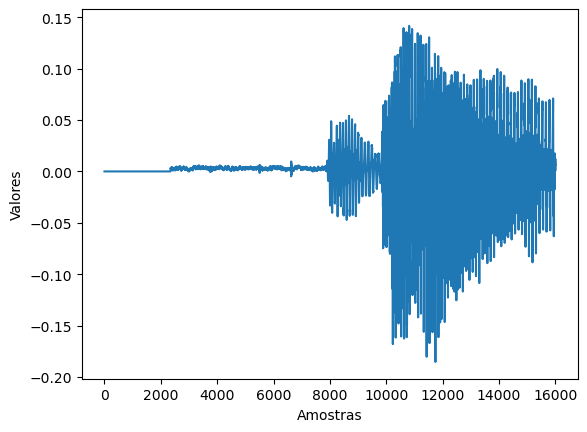

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(z)
plt.ylabel('Valores')
plt.xlabel('Amostras')
plt.show()

# Exercício 2
**Objetivo: visualizr os MFCCs de uma gravação**

Mel-Frequency Cepstral Coefficients são coeficientes que formam um vetor que descreve o timbre. A ideia dos MFCCs é encontrar o quanto da atividade da glote está excitando cada uma das bandas críticas do ouvido. Na prática, isso nos dá uma sequência de vetores ao longo do tempo.

À partir do código abaixo, mostre, em painéis próximos, os MFCCs de exemplos das palavras "yes", "no" e "go". Quais deles são mais diferentes entre si?

In [5]:
import numpy as np

(12, 27)


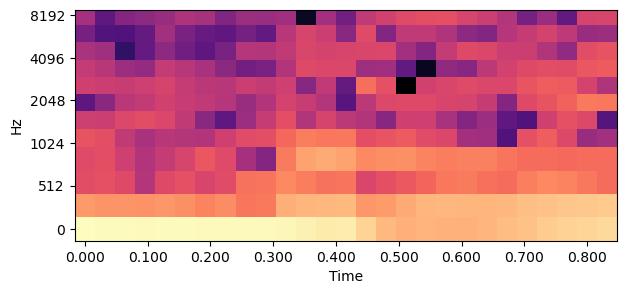

In [6]:
S = np.abs(librosa.feature.mfcc(y=y, sr=sr, n_mels=12))
print(S.shape)
plt.figure( figsize=(7,3))
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                                y_axis='mel', sr=sr, x_axis='time',
                                fmax=8000)
plt.show()

In [18]:
def get_spectrogram(fname):
    y, sr = librosa.load(fname, sr=None)
    y = y-np.mean(y)
    y = y / np.std(y)
    if y.shape[0] > 16000:
        y = y[0:16000]
    if y.shape[0] < 16000:
        y = np.hstack ( (np.zeros(16000-y.shape[0]), y)  )
    S = np.abs(librosa.feature.mfcc(y=y, sr=sr, n_mels=12))
    return S.T

# Exercício 3
**Objetivo: organizar o dataset de palavras em batches**

Um problema de datasets de mídia é que geralmente abri-los demanda muita memória do computador. O código abaixo organiza o dataset `mini_speech_commands` em batches, e garante que só abrimos os arquivos quando formos utilizá-los.

1. A classe `MeuDataset` tem 5 métodos. Quais são eles e qual é a importância de cada um deles?
1. Como poderíamos dividir a base de dados em conjuntos isolados para treino, validação e teste?

In [19]:
# Varrer diretorio do dataset e encontrar subdiretorios
import os
from tqdm import tqdm
dataset_dir = "./datasets/speech_commands/mini_speech_commands/"
k=0
dotwave = '.wav'
fnames, labels = [], []
for label in tqdm(os.listdir(dataset_dir)):
    if label.endswith('.md'):
        continue
    for fname in os.listdir(dataset_dir + label):
        if fname.endswith(dotwave):
            fnames.append(label + "/" + fname)
            labels.append(label)

print("Done!", len(fnames), len(labels))

100%|██████████| 9/9 [00:00<00:00, 196.94it/s]

Done! 8000 8000


In [14]:

class MeuDataset(tf.keras.utils.Sequence):
    

    def __init__(self, dataset_dir, list_of_files, list_of_labels, batch_size):
        self.batch_size = batch_size
        self.dataset_dir = dataset_dir
        self.list_of_files = list_of_files
        self.list_of_labels = list_of_labels
        self.label_vocab = list(set(self.list_of_labels))
        self._shuffle()
        
    def __len__(self):
        return int(np.ceil(len(self.list_of_labels) / self.batch_size))

    def __getitem__(self, idx):
        # Retorna pares de entrada e saída do batch idx
        X = []
        y = []
        for k in range(self.batch_size):
            if (k + idx*self.batch_size + 1) > len(self.list_of_files):
                break
            S = get_spectrogram(self.dataset_dir + "/" + self.list_of_files[k+idx*self.batch_size])
            X.append(S)
            y.append(self.label_vocab.index(self.list_of_labels[k+idx*self.batch_size]))

        X = np.array(X)
        y = np.array(y).reshape( (-1, 1))
        return X, y
    
    def _shuffle(self):
        import random
        temp = list(zip(self.list_of_files, self.list_of_labels))
        random.shuffle(temp)
        res1, res2 = zip(*temp)
        # res1 and res2 come out as tuples, and so must be converted to lists.
        self.list_of_files, self.list_of_labels = list(res1), list(res2)

    def on_epoch_end(self):
        self._shuffle()
    

In [15]:
dataset = MeuDataset(dataset_dir, fnames, labels, 1024)
X, y = dataset.__getitem__(2)
print(X.shape)
print(y.shape)
print(len(dataset.label_vocab))

(1024, 32, 64)
(1024, 1)
8


# Exercício 4
**Objetivo: projetar e treinar um sistema para classificação de palavras de comando**

Um sistema de classificação de palavras de comando é, essencialmente, um classificador de sequências que recebe uma sequência de MFCCs como entrada. Porém, a estrutura interna pode variar bastante: podemos usar LSTMs, GRUs, CNNs, multi-head attention, etc. - e cada uma dessas variedades ainda pode ter uma grande diversidade de parâmetros.

Encontre algum artigo científico (por exemplo, em bases do IEEE, ACM, Google Scholar, etc.) que descreva algum modelo de reconhecimento de sequências que foi usado para reconhecimento de palavras isoladas. Com base no artigo, projete seu próprio reconhecedor de sequências, incluindo o tipo de camada, o número de camadas e o tamanho de cada projeção. Após, treine seu classificador e avalie. Você consegue os mesmos resultados que os encontrados no artigo?

In [36]:
from keras.layers import Input, BatchNormalization, GRU, Dense, Activation, TimeDistributed, Softmax, MultiHeadAttention, TextVectorization, Reshape, RepeatVector, Conv1D, Bidirectional, AveragePooling1D, UpSampling1D, Embedding, Concatenate, GlobalAveragePooling1D, LSTM, Multiply
from keras.models import Model

def model():
  input_layer = Input(shape=(32, 12))
  x = input_layer
  x = LSTM(2)(x)
  y = Dense(8, activation='softmax', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = model()
rede_neural.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
rede_neural.fit(dataset, epochs=5)

Epoch 1/5
8/8 [==============================] - 55s 6s/step - loss: 2.0854 - accuracy: 0.0494
Epoch 2/5
8/8 [==============================] - 63s 8s/step - loss: 2.0844 - accuracy: 0.0000e+00
Epoch 3/5
8/8 [==============================] - 61s 8s/step - loss: 2.0838 - accuracy: 0.0000e+00
Epoch 4/5
8/8 [==============================] - 58s 7s/step - loss: 2.0831 - accuracy: 0.0000e+00
Epoch 5/5
8/8 [==============================] - 62s 8s/step - loss: 2.0825 - accuracy: 0.0012
